# `BUILDING A ML MODEL TO PREDICT ETA FOR YASSIR RIDE HAILING COMPANY` 
#### Using the CRISP-DM framework

## `Business Understanding`


#### Goal/Description
To create a machine learning model to predict the eta for yassir to improve reliability and attractiveness to customers.

#### `Null Hypothesis`
There is no relationship between the mean of eta of trip distances above trip distance mean and mean of eta of all trips

#### `Alternate Hypothesis`
There is a relationship between the mean of eta of trip distances above trip distance mean and mean of eta of all trips

### `Key Metrics and Success Criteria`

The success of this poject will be evaluated based on several key metrics and success criteria including;

• Model Accuracy : The ability of the machine learning model to have minimum margin of error

• Model Interpretability : The degree to which the model's predictions and insights can be understood and utilized by stakeholders.

#### `Analytical Questions`

- Which days of the month has the highest ride orders?
- Which hours of the day have the maximum ride orders?
- Which hours of the day have the lowest ride orders?
- Does wind speed impact ETA?
- Is Trip distance and ETA affected by dewpoint in the early hours of the day?
- What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

## `Data Understanding`

#### Data Source
The data was sourced from Zindi website:
- A train dataset 
- A weather dataset
- A test dataset
 

#### Data Features

- TimeStamp: Identifies the store at which the products are sold.

- Origin_Lat,Origin_Lon : Pickup point

- Destination_lat,Destination_Lon : Dropoff point

- ETA : Estimated Time of arrival

- Trip distance : Distance between origin gps coordinates and destination gps coordinates 



#### Data Exploration

##### `Libraries`

In [2]:
#Libraries imported
import pandas as pd
import numpy as np
from scipy import stats 
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import plotly.express as px

import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

from sklearn.svm import SVR 
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
import joblib




In [3]:
##Accessing the train data 
df = pd.read_csv("data/train_data.csv",parse_dates = ['Timestamp'])
df.tail(10)
print(len(df))

83924


In [4]:
##Accessing the weather data 
w_df = pd.read_csv("data/Weather_data.csv",parse_dates = ['date'])
w_df.head(10)

,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
0,2019-11-01,290.630524,296.434662,294.125061,101853.617188,292.503998,100806.351562,0.004297,3.561323,0.941695
1,2019-11-02,289.135284,298.432404,295.551666,101225.164062,293.337921,100187.250000,0.001767,5.318593,3.258237
2,2019-11-03,287.667694,296.612122,295.182831,100806.617188,293.674316,99771.414062,0.000797,8.447649,3.172982
3,2019-11-04,287.634644,297.173737,294.368134,101240.929688,292.376221,100200.843750,0.000393,5.991428,2.236700
4,2019-11-05,286.413788,294.284851,292.496979,101131.750000,289.143066,100088.500000,0.004658,6.962730,2.655364
5,2019-11-06,283.408783,292.336121,289.727631,101370.937500,287.188354,100318.976562,0.005435,5.762590,0.564045
6,2019-11-07,283.211395,293.419891,290.415192,101249.843750,286.823730,100201.875000,0.000248,4.003057,2.685759
7,2019-11-08,281.389923,290.577393,288.396332,101331.351562,286.591522,100274.304688,0.005572,6.604807,0.676897
8,2019-11-09,280.681366,291.216400,289.184479,101801.195312,286.891205,100742.281250,0.000360,7.459220,0.228752
9,2019-11-10,282.495880,287.458679,286.003326,101158.304688,283.836639,100094.710938,0.029922,4.831686,0.762374


In [5]:
#Split Datetime 
# Extract date into a new column
df['date'] = df['Timestamp'].dt.date
df = df.sort_values(by='Timestamp')
df.head(3)


,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,date
72164,UYFJUFF0,2019-11-19 23:00:08+00:00,3.021,36.751,3.031,36.769,3898,556,2019-11-19
23738,A5O0F035,2019-11-19 23:00:10+00:00,2.972,36.760,3.006,36.728,5861,785,2019-11-19
12253,5773G56H,2019-11-19 23:00:38+00:00,2.850,36.682,3.048,36.784,26065,1661,2019-11-19


In [6]:
#merge the two datasets
# Convert 'date' columns to datetime
df['date'] = pd.to_datetime(df['date'])
w_df['date'] = pd.to_datetime(w_df['date'])

# Merge DataFrames on 'date' column

merged_df = pd.merge(df, w_df, on='date', how='left')
print(len(merged_df))

83924


In [7]:
merged_df['day'] = merged_df['date'].dt.day_name()
merged_df['daynumber'] = merged_df['date'].dt.day
merged_df['hour'] = merged_df['Timestamp'].dt.hour
merged_df.head(5)

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,date,dewpoint_2m_temperature,...,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m,day,daynumber,hour
0,UYFJUFF0,2019-11-19 23:00:08+00:00,3.021,36.751,3.031,36.769,3898,556,2019-11-19,281.222931,...,285.203339,101709.28125,282.853973,100640.476562,0.003459,3.198985,0.879467,Tuesday,19,23
1,A5O0F035,2019-11-19 23:00:10+00:00,2.972,36.760,3.006,36.728,5861,785,2019-11-19,281.222931,...,285.203339,101709.28125,282.853973,100640.476562,0.003459,3.198985,0.879467,Tuesday,19,23
2,5773G56H,2019-11-19 23:00:38+00:00,2.850,36.682,3.048,36.784,26065,1661,2019-11-19,281.222931,...,285.203339,101709.28125,282.853973,100640.476562,0.003459,3.198985,0.879467,Tuesday,19,23
3,V9U1CHGP,2019-11-19 23:00:44+00:00,2.984,36.757,3.005,36.777,4943,629,2019-11-19,281.222931,...,285.203339,101709.28125,282.853973,100640.476562,0.003459,3.198985,0.879467,Tuesday,19,23
4,6J9AO2C8,2019-11-19 23:00:53+00:00,2.861,36.761,3.186,36.721,37492,2181,2019-11-19,281.222931,...,285.203339,101709.28125,282.853973,100640.476562,0.003459,3.198985,0.879467,Tuesday,19,23


### DATA UNDERSTANDING

In [8]:
#Checking for missing values
merged_df.isnull().sum()

ID                            0
Timestamp                     0
Origin_lat                    0
Origin_lon                    0
Destination_lat               0
Destination_lon               0
Trip_distance                 0
ETA                           0
date                          0
dewpoint_2m_temperature       0
maximum_2m_air_temperature    0
mean_2m_air_temperature       0
mean_sea_level_pressure       0
minimum_2m_air_temperature    0
surface_pressure              0
total_precipitation           0
u_component_of_wind_10m       0
v_component_of_wind_10m       0
day                           0
daynumber                     0
hour                          0
dtype: int64

In [9]:
# Describing the Dataframe
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
ID,83924,83924,5L5VMG68,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Timestamp,83924,NaN,NaN,NaN,2019-12-04 14:22:20.568883712+00:00,2019-11-19 23:00:08+00:00,2019-11-27 01:53:00.500000+00:00,2019-12-04 01:46:50.500000+00:00,2019-12-11 21:36:44+00:00,2019-12-19 23:59:29+00:00,NaN
Origin_lat,83924.0,NaN,NaN,NaN,3.052406,2.807,2.994,3.046,3.095,3.381,0.096388
Origin_lon,83924.0,NaN,NaN,NaN,36.739358,36.589,36.721,36.742,36.76,36.82,0.032074
Destination_lat,83924.0,NaN,NaN,NaN,3.056962,2.807,2.995,3.049,3.109,3.381,0.10071
Destination_lon,83924.0,NaN,NaN,NaN,36.737732,36.596,36.718,36.742,36.76,36.819,0.032781
Trip_distance,83924.0,NaN,NaN,NaN,13527.82141,1.0,6108.0,11731.5,19369.0,62028.0,9296.716006
ETA,83924.0,NaN,NaN,NaN,1111.697762,1.0,701.0,1054.0,1456.0,5238.0,563.565486
date,83924,NaN,NaN,NaN,2019-12-03 22:34:17.633096448,2019-11-19 00:00:00,2019-11-27 00:00:00,2019-12-04 00:00:00,2019-12-11 00:00:00,2019-12-19 00:00:00,NaN


##### General Observation
- There are 83924 trips recorded in the time period
- Highest ETA recorded is 5238 secs while the average ETA is 111.69 secs
- Average trip distance is 13527.82 m

### EDA

### Univariate Analysis

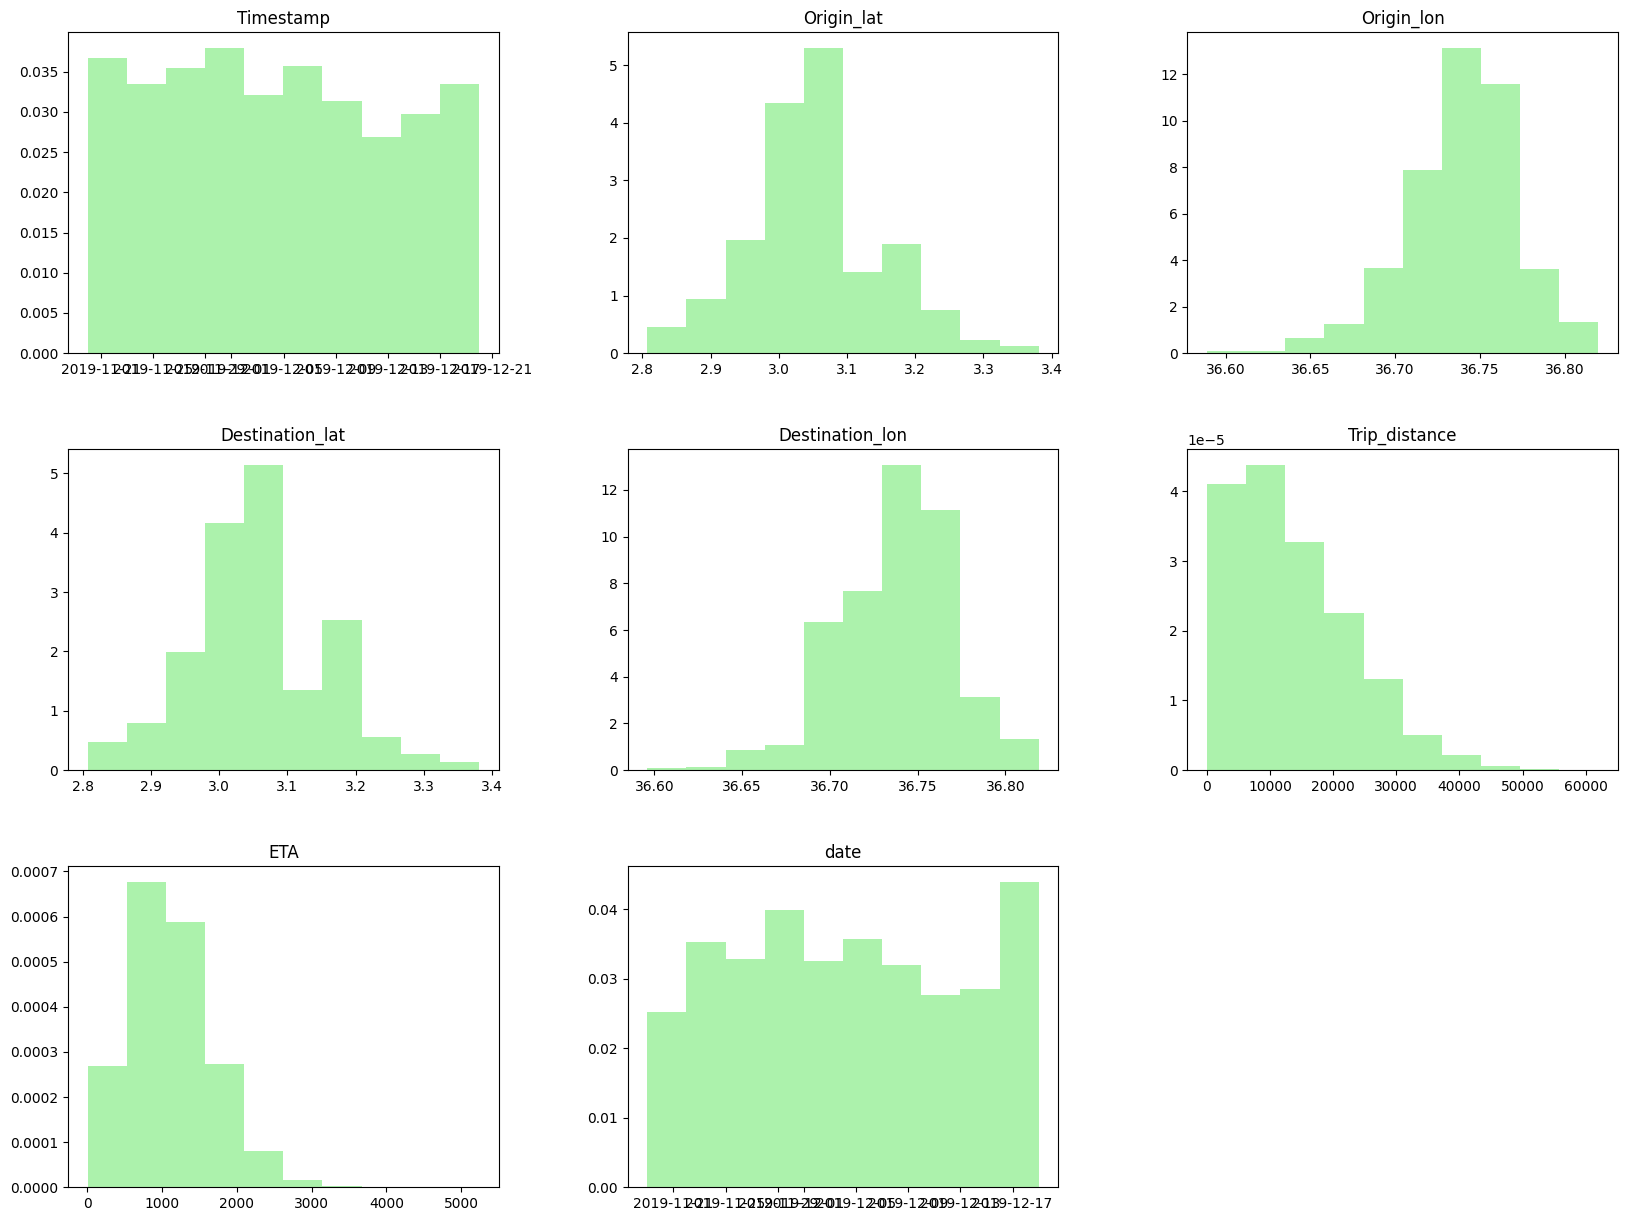

In [10]:
# Distribution of the variables
df.hist(density = True,figsize = (20, 15), facecolor = 'lightgreen', alpha = 0.75,grid = False)

plt.show()

##### BiVariate Analysis

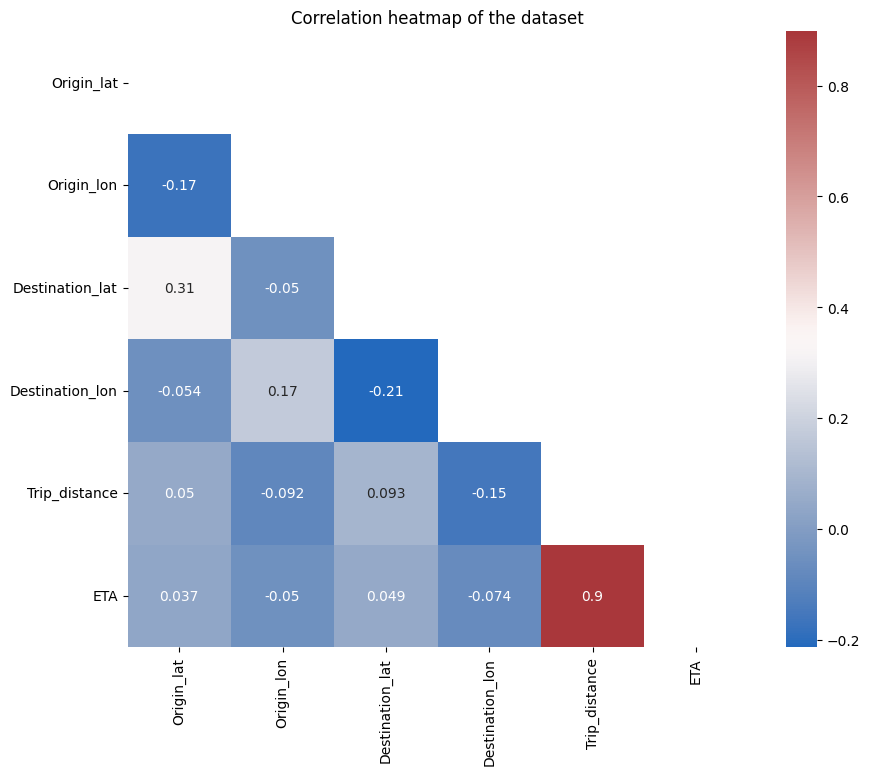

In [11]:
# Summarize the relationships between the variables with a heatmap of the correlations
correlation_matrix = df.corr(numeric_only= True).round(3)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix, annot=True,cmap='vlag',mask=mask)
plt.title("Correlation heatmap of the dataset")
plt.show()

## `Answering the Analytical Questions`

- Which days of the month has the highest ride orders?
- Which hours of the day have the maximum ride orders?
- Which hours of the day have the lowest ride orders?
- Does wind speed impact ETA?
- Is Trip distance and ETA affected by dewpoint in the early hours of the day?
- What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

##### `Which days of the month has the highest ride orders?`

In [12]:
analytic_data = df.copy()
analytic_data['day'] = analytic_data['date'].dt.day_name()
analytic_data.head(5)

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,date,day
72164,UYFJUFF0,2019-11-19 23:00:08+00:00,3.021,36.751,3.031,36.769,3898,556,2019-11-19,Tuesday
23738,A5O0F035,2019-11-19 23:00:10+00:00,2.972,36.760,3.006,36.728,5861,785,2019-11-19,Tuesday
12253,5773G56H,2019-11-19 23:00:38+00:00,2.850,36.682,3.048,36.784,26065,1661,2019-11-19,Tuesday
72918,V9U1CHGP,2019-11-19 23:00:44+00:00,2.984,36.757,3.005,36.777,4943,629,2019-11-19,Tuesday
15344,6J9AO2C8,2019-11-19 23:00:53+00:00,2.861,36.761,3.186,36.721,37492,2181,2019-11-19,Tuesday


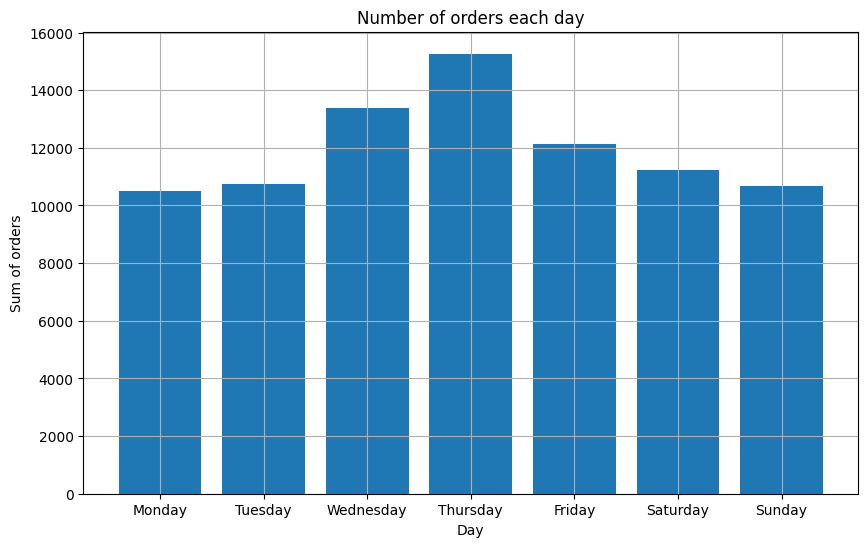

In [20]:
filt = analytic_data.groupby('day')['Origin_lat'].count()
filt = filt.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(filt.index, filt.values)
plt.title('Number of orders each day')
plt.xlabel('Day')
plt.ylabel('Sum of orders')
plt.grid(True)
plt.show()

##### `Which hours of the day have the highest ride orders?`

In [14]:
analytic_data['hour'] = analytic_data['Timestamp'].dt.hour
analytic_data

,ID,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,date,day,hour
72164,UYFJUFF0,2019-11-19 23:00:08+00:00,3.021,36.751,3.031,36.769,3898,556,2019-11-19,Tuesday,23
23738,A5O0F035,2019-11-19 23:00:10+00:00,2.972,36.760,3.006,36.728,5861,785,2019-11-19,Tuesday,23
12253,5773G56H,2019-11-19 23:00:38+00:00,2.850,36.682,3.048,36.784,26065,1661,2019-11-19,Tuesday,23
72918,V9U1CHGP,2019-11-19 23:00:44+00:00,2.984,36.757,3.005,36.777,4943,629,2019-11-19,Tuesday,23
15344,6J9AO2C8,2019-11-19 23:00:53+00:00,2.861,36.761,3.186,36.721,37492,2181,2019-11-19,Tuesday,23
...,...,...,...,...,...,...,...,...,...,...,...
3524,1ID05SCC,2019-12-19 23:58:39+00:00,3.052,36.773,2.980,36.754,11650,1019,2019-12-19,Thursday,23
36583,FPTS95LV,2019-12-19 23:59:01+00:00,3.052,36.773,2.980,36.753,11650,1019,2019-12-19,Thursday,23
10788,4J9YL24R,2019-12-19 23:59:21+00:00,3.063,36.724,3.074,36.752,8191,926,2019-12-19,Thursday,23
53982,N8497SX3,2019-12-19 23:59:25+00:00,3.032,36.770,3.029,36.758,2617,299,2019-12-19,Thursday,23


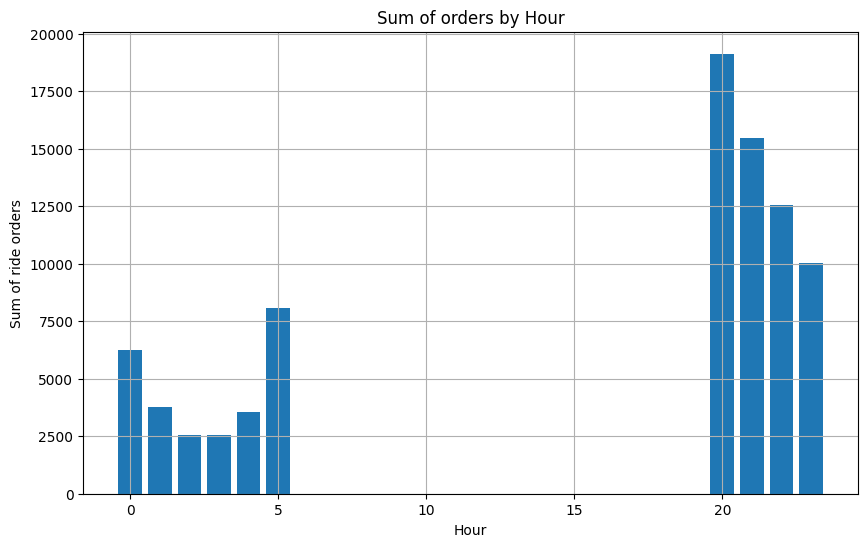

In [21]:
filt = analytic_data.groupby('hour')['ETA'].count()

filt = filt.reindex([0,1,2,3,4,5,20,21,22,23,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(filt.index, filt.values)
plt.title('Sum of orders by Hour')
plt.xlabel('Hour')
plt.ylabel('Sum of ride orders')
plt.grid(True)
plt.show()

##### `Does wind speed impact ETA?`

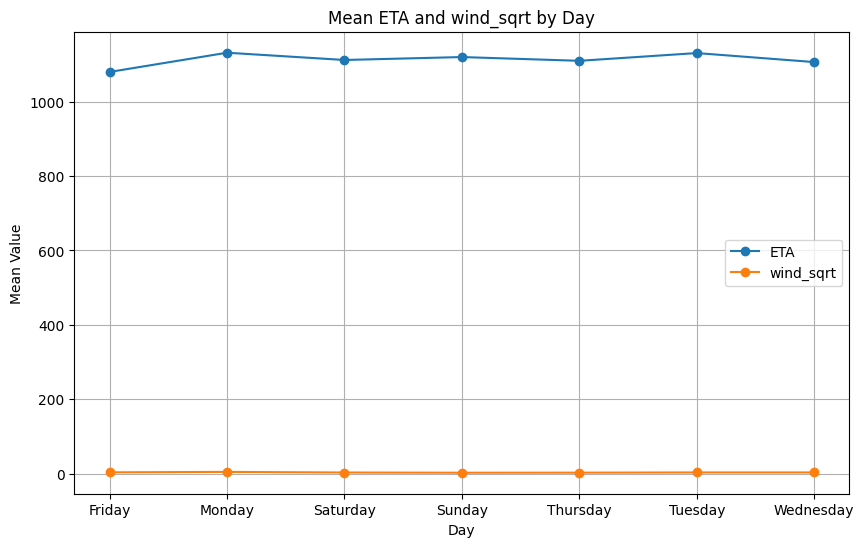

In [16]:
# Calculating wind speed
merged_df['wind_sqrt'] = np.sqrt((merged_df['u_component_of_wind_10m'] ** 2) + (merged_df['v_component_of_wind_10m'] ** 2))

filt=merged_df.groupby('day')[['ETA','wind_sqrt']].mean()
# Plotting
plt.figure(figsize=(10, 6))

# Plot ETA
plt.plot(filt.index, filt['ETA'], label='ETA', marker='o')

# Plot wind_sqrt
plt.plot(filt.index, filt['wind_sqrt'], label='wind_sqrt', marker='o')

# Adding title and labels
plt.title('Mean ETA and wind_sqrt by Day')
plt.xlabel('Day')
plt.ylabel('Mean Value')

# Adding legend
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()

##### `Is Trip distance and ETA affected by dewpoint in the early hours of the day?'

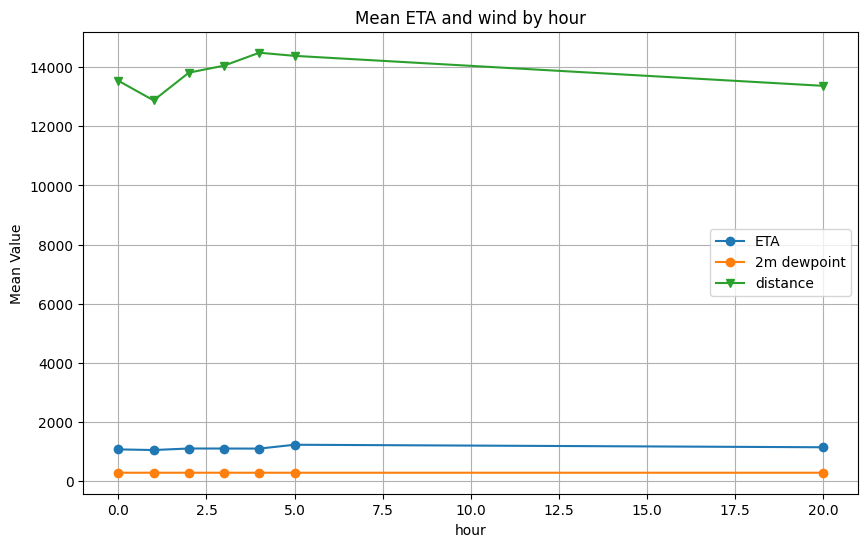

In [17]:
filt = merged_df.groupby('hour')[['Trip_distance','ETA','dewpoint_2m_temperature']].mean().head(7)
# Plotting
plt.figure(figsize=(10, 6))

# Plot ETA
plt.plot(filt.index, filt['ETA'], label='ETA', marker='o')

# Plot wind_sqrt
plt.plot(filt.index, filt['dewpoint_2m_temperature'], label='2m dewpoint', marker='o')

# Plot wind_sqrt
plt.plot(filt.index, filt['Trip_distance'], label='distance', marker='v')

# Adding title and labels
plt.title('Mean ETA and wind by hour')
plt.xlabel('hour')
plt.ylabel('Mean Value')

# Adding legend
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()

#### `HYPOTHESIS`

In [18]:


distance_above_mean = merged_df.loc[(merged_df['Trip_distance'] > merged_df.Trip_distance.mean())]

# Perform t-test
t_stat, p_value = ttest_ind(distance_above_mean.ETA, merged_df.ETA)

print(f"t-statistic: {t_stat}, p-value: {p_value}")

if p_value < 0.05:
    print("The difference between the group means is statistically significant.")
    print(f"Reject null hypothesis >> Since the p_value {p_value} is less than 0.05")
else:
    print("The difference between the group means is not statistically significant.")
    print(f"Fail to reject null hypothesis >> Since the p_value {p_value} is greater than 0.05")

t-statistic: 139.56102603903736, p-value: 0.0
The difference between the group means is statistically significant.
Reject null hypothesis >> Since the p_value 0.0 is less than 0.05


In [22]:
## Test for stationarity using AD Fuller Test

from statsmodels.tsa.stattools import adfuller
 

# ADF Test
result = adfuller(df.ETA)
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
if result[1] > 0.05:
    print('The AdFuller test fails to reject the null hypothesis and therefore is not Stationary')
else:
    print('The Series is stationary')

ADF Statistic: -29.40162172723199
n_lags: 0.0
p-value: 0.0
Critial Values:
   1%, -3.43042797651185
Critial Values:
   5%, -2.8615744643235153
Critial Values:
   10%, -2.5667883441661514
The Series is stationary


### `Data preparation`
## `Feature Engineering`

<Axes: xlabel='gaussian_mean_sea_level', ylabel='Density'>

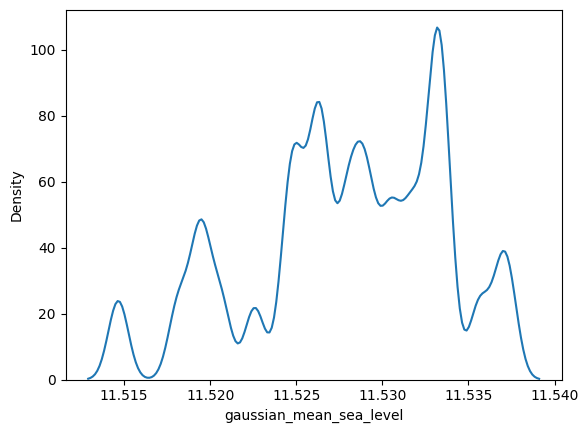

In [ ]:
# Apply log transformation to 'feature1'
merged_df['log_eta'] = np.log1p(merged_df['ETA'])
#merged_df['log_surface_pressure'] = np.log1p(merged_df['surface_pressure'])
#merged_df['log_mean_sea_level'] = np.log1p(merged_df['mean_sea_level_pressure'])
merged_df['log_mean_2m_air_temperature'] = np.log1p(merged_df['mean_2m_air_temperature'])

#cube root
merged_df['log_Trip_distance'] = np.cbrt(merged_df['Trip_distance'])

# Apply inverse log transformation to 'log_feature1'
merged_df['log_total_precipitation'] = np.expm1(merged_df['total_precipitation'])



# Apply Gaussian filter with a sigma of 1
merged_df['gaussian_surface_pressure'] = gaussian_filter1d(np.log1p(merged_df['surface_pressure']), sigma=1)
merged_df['gaussian_mean_sea_level'] = gaussian_filter1d(np.log1p(merged_df['mean_sea_level_pressure']), sigma=1)
merged_df['gaussian_mean_total_precipitation'] = gaussian_filter1d(merged_df['log_total_precipitation'], sigma=1)
merged_df['gaussian_dewpoint_2m_temperature'] = gaussian_filter1d(np.log1p(merged_df['dewpoint_2m_temperature']), sigma=1)



#sns.kdeplot(merged_df['surface_pressure'])
sns.kdeplot(merged_df['gaussian_mean_sea_level'])


In [ ]:
def cleaner(df,w_df):
    df['date'] = df['Timestamp'].dt.date
    df = df.sort_values(by='Timestamp')
    df['date'] = pd.to_datetime(df['date'])
    w_df['date'] = pd.to_datetime(w_df['date'])

    # Merge DataFrames on 'date' column

    merged_df = pd.merge(df, w_df, on='date', how='left')
    merged_df['day']= merged_df['date'].dt.day_name()
    merged_df['daynumber']= merged_df['date'].dt.day
    merged_df['hour']= merged_df['Timestamp'].dt.hour

    # Calculating wind speed
    merged_df['wind_sqrt'] = np.sqrt((merged_df['u_component_of_wind_10m'] ** 2) + (merged_df['v_component_of_wind_10m'] ** 2))
    # Apply log transformations
    merged_df['log_mean_2m_air_temperature'] = np.log1p(merged_df['mean_2m_air_temperature'])
    merged_df['log_Trip_distance'] = np.expm1(merged_df['Trip_distance'])

    # Apply inverse log transformation
    merged_df['log_total_precipitation'] = np.expm1(merged_df['total_precipitation'])

    #Smoothening some columns
    # Apply Gaussian filter with a sigma of 1
    merged_df['gaussian_surface_pressure'] = gaussian_filter1d(np.log1p(merged_df['surface_pressure'], sigma=1))
    merged_df['gaussian_mean_sea_level'] = gaussian_filter1d(np.log1p(merged_df['mean_sea_level_pressure'], sigma=1))
    merged_df['gaussian_mean_total_precipitation'] = gaussian_filter1d(merged_df['log_total_precipitation'], sigma=4)
    merged_df['gaussian_dewpoint_2m_temperature'] = gaussian_filter1d(np.log1p(merged_df['dewpoint_2m_temperature'], sigma=1))

    merged_df.drop(columns=['Origin_lat','Origin_lon','Destination_lat','Destination_lon','ID','date','daynumber','Trip_distance','Timestamp',
                              'maximum_2m_air_temperature','mean_2m_air_temperature','mean_sea_level_pressure','dewpoint_2m_temperature',
                              'day','minimum_2m_air_temperature','surface_pressure','u_component_of_wind_10m','v_component_of_wind_10m',
                              'gaussian_mean_total_precipitation','ETA','wind_sqrt','total_precipitation','log_total_precipitation'],axis=1,inplace=True)
    return merged_df

In [ ]:
#Saving the function
joblib.dump(cleaner,'models/cleaner.joblib')

['models/cleaner.joblib']

In [ ]:
merged = merged_df.copy()

In [ ]:
# Select columns of interest
selected_columns = merged_df[['Timestamp','date','daynumber','hour','log_mean_2m_air_temperature','gaussian_surface_pressure','gaussian_dewpoint_2m_temperature',
                              'gaussian_mean_sea_level','gaussian_mean_total_precipitation','wind_sqrt','log_Trip_distance','Trip_distance','log_eta','ETA']]

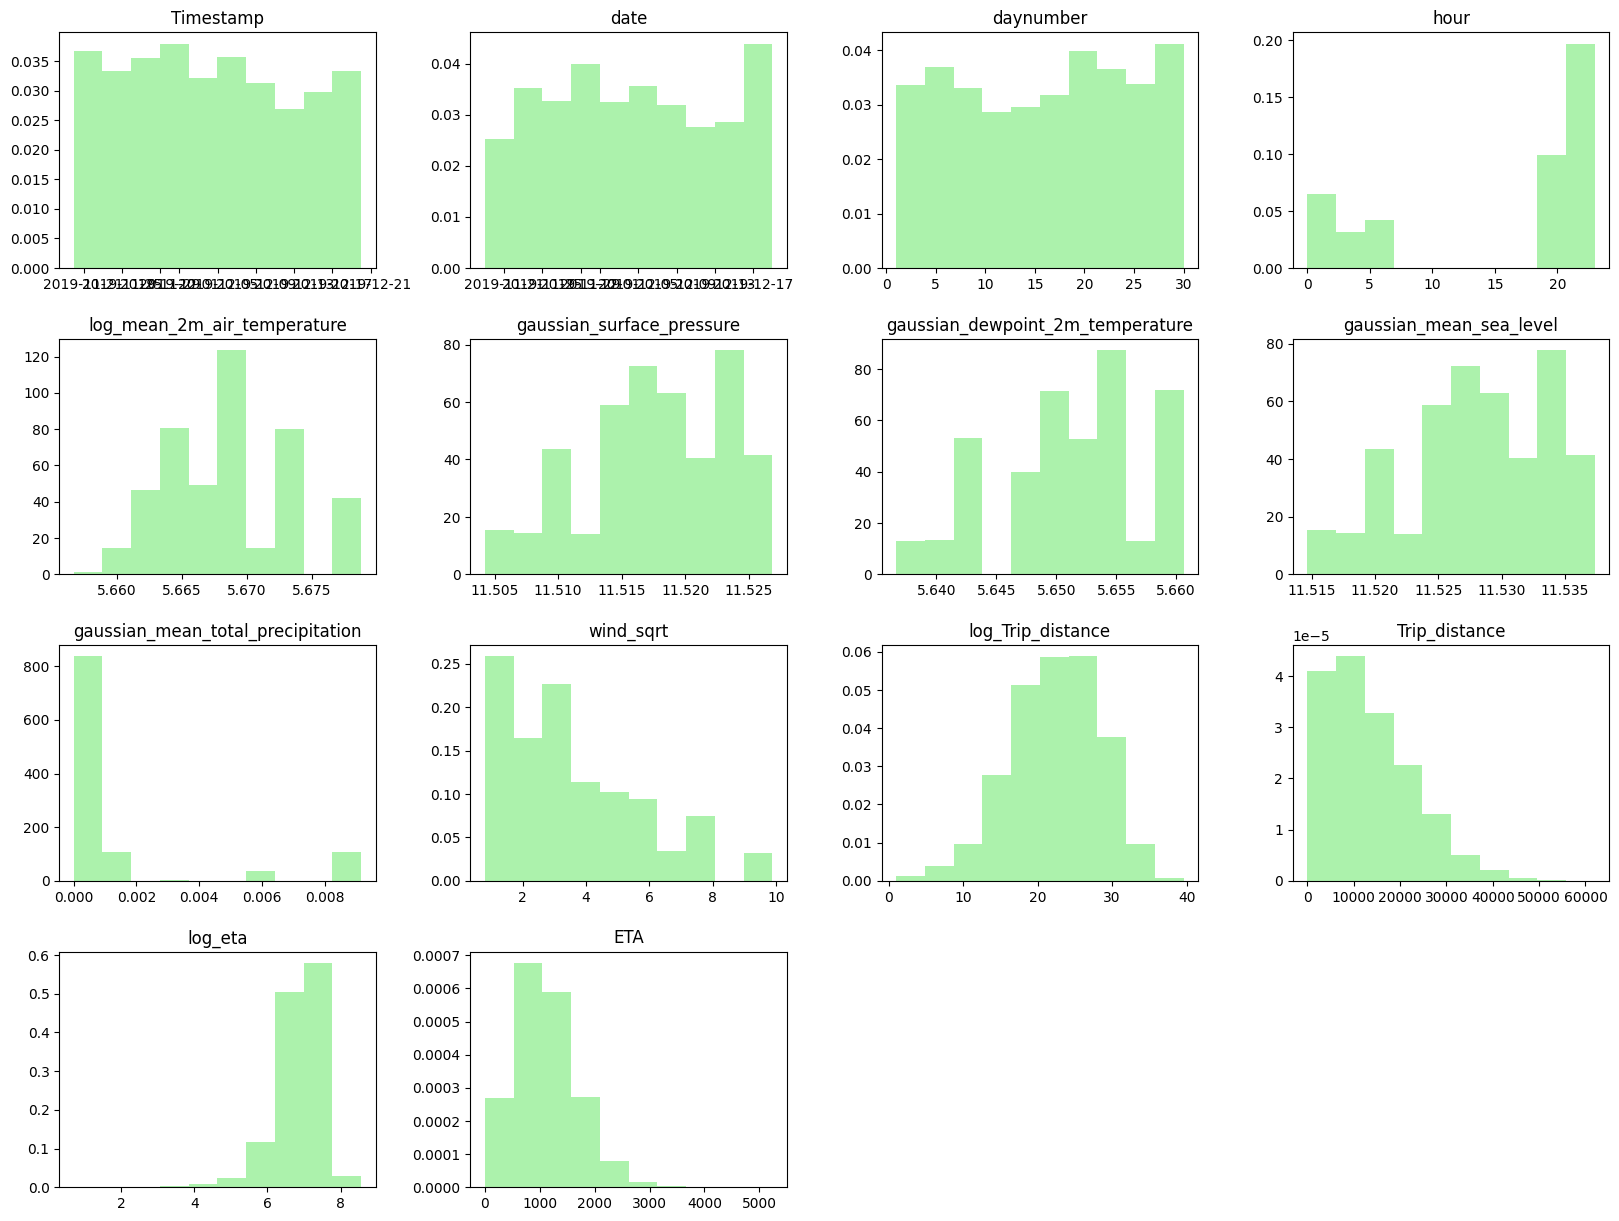

In [ ]:
# Distribution of the variables
selected_columns.hist(density = True,figsize = (20, 15), facecolor = 'lightgreen', alpha = 0.75,grid = False)

plt.show()

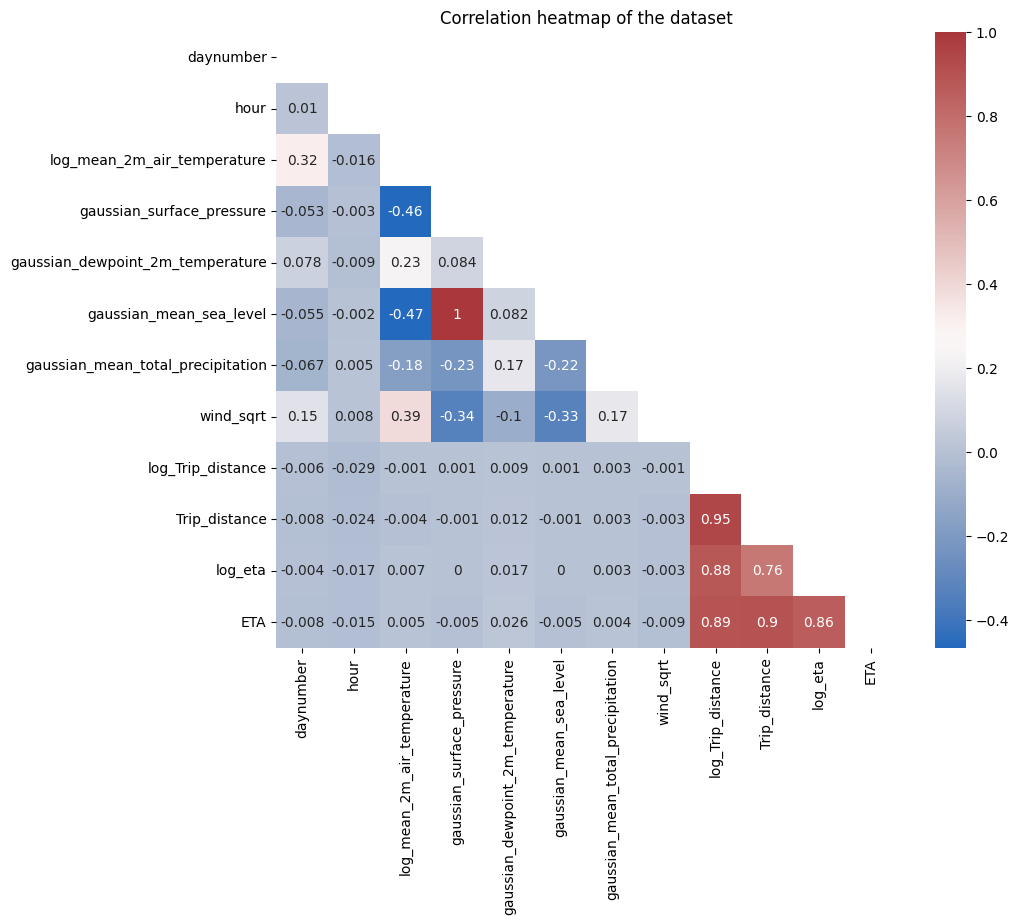

In [ ]:
# Summarize the relationships between the variables with a heatmap of the correlations
correlation_matrix = selected_columns.corr(numeric_only= True).round(3)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix, annot=True,cmap='vlag',mask=mask)
plt.title("Correlation heatmap of the dataset")
plt.show()

In [ ]:
X=selected_columns.drop(columns=['date','daynumber','hour','Trip_distance','Timestamp',
                              'gaussian_mean_total_precipitation','ETA','log_eta','wind_sqrt'],axis=1)
y=selected_columns['log_eta']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 27)

In [ ]:
# create an SVR model with a linear kernel 
model= SVR(kernel='rbf',max_iter = 2000,gamma = 'auto') 
model.fit(X_train, y_train)

SVR(gamma='auto', max_iter=2000)

In [ ]:
# Predictions
y_pred= (model.predict(X_test))

In [ ]:
# Compute the inverse log (exponential)
original_values = np.expm1(y_pred) 

print(original_values)

[ 83.04100305  82.5180972   82.72146036 ... 140.81668194  93.60011999
  80.29250775]


In [ ]:
# Evaluate the model
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 1025.1311229557948
Mean Squared Error (MSE): 1342872.537284124
Root Mean Squared Error (RMSE): 1158.8237731787021


In [ ]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)
# Predictions
y_pred= (model.predict(X_test))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 41962, number of used features: 5
[LightGBM] [Info] Start training from score 6.843336


In [ ]:
# Compute the inverse log (exponential)
original_values = y_pred

print(original_values)

# Evaluate the model
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


[6.75874252 6.96462793 6.70070112 ... 7.5477686  7.40508594 7.09673891]
Mean Absolute Error (MAE): 167.65682015491848
Mean Squared Error (MSE): 55557.54032588488
Root Mean Squared Error (RMSE): 235.70647069158895


In [ ]:
# Initialize the XGBRegressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict the target values for the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 168.07915588119772
Mean Squared Error (MSE): 55900.765988998
Root Mean Squared Error (RMSE): 236.43342823932068


In [ ]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 195.94510921306326
Mean Squared Error (MSE): 89727.72100860323
Root Mean Squared Error (RMSE): 299.5458579393199


In [ ]:
# Initialize and train the model
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

# Predict the target values for the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 213.0587108733813
Mean Squared Error (MSE): 88759.1974799669
Root Mean Squared Error (RMSE): 297.9248185028681


In [ ]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 174.41989057542193
Mean Squared Error (MSE): 60285.350279644015
Root Mean Squared Error (RMSE): 245.5307522076288


In [ ]:
# Create a dictionary of the model pipelines
all_models_pipelines = {
              "Linear_Regression": LinearRegression(n_jobs=-1),
              "SVR": SVR(kernel='rbf',max_iter = 2000,gamma = 'auto'),
              "Xgboost":XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
              "LBM" : lgb.LGBMRegressor(),
              "D_Tree" : DecisionTreeRegressor(random_state=42),
              "K-NN" : KNeighborsRegressor(n_neighbors=5),
              }
    

In [ ]:
def evaluate_models(model_pipelines = all_models_pipelines, X_test = X_test, y_test = y_test):


    # Dictionary for trained models
    trained_models = dict()

    # Create a dataframe matrix to all pipelines
    all_confusion_matrix = []
    
    
    # List to receive scores
    performances = []
    for name, model_pipeline in model_pipelines.items():
        final_pipeline = model_pipeline
    


        
        final_pipeline.fit(X_train,  y_train)
       

        # Predict and calculate performance scores
        y_pred = final_pipeline.predict(X_test)
        performances.append([name,
                             mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)),
                             mean_squared_error(np.expm1(y_test), np.expm1(y_pred)),
                             np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
                             ])


        # Store trained model
        trained_model_name = "trained_" + str(name).lower()
        trained_models[trained_model_name] = final_pipeline
        
        print("\n", "-----   -----"*6, "\n",  "-----   -----"*6)
        # Compile accuracy
    df_compare = pd.DataFrame(performances, columns = ["model", "mae", "mse", "rmse"])
    df_compare.set_index("model", inplace = True)
    df_compare.sort_values(by = ["rmse", "mae"], ascending = False, inplace=True)
    return df_compare, trained_models

In [ ]:
# Run the function to train models and return performances
all_models_eval, trained_models = evaluate_models()
all_models_eval


 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   -----

 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   -----

 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ----------   ----------   ----------   ----------   -----
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 41962, number of used features: 5
[LightGBM] [Info] Start training from score 6.843336

 -----   ----------   ----------   ----------   ----------   ----------   ----- 
 -----   ----------   ------

,mae,mse,rmse
model,,,
SVR,1025.131123,1.342873e+06,1158.823773
D_Tree,195.945109,8.972772e+04,299.545858
Linear_Regression,213.058711,8.875920e+04,297.924819
K-NN,174.419891,6.028535e+04,245.530752
Xgboost,168.079156,5.590077e+04,236.433428
LBM,167.656820,5.555754e+04,235.706471


#### `HYPERPARAMETER TUNING`

In [ ]:
# Define the parameter grid
param_grid = {
    'booster' : ['dart'],
    'n_estimators': [200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [ 7],
    'min_child_weight': [5],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6]
}

xg_reg = XGBRegressor(objective='reg:squarederror')

# Perform grid search
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, scoring='neg_mean_squared_error', verbose=1,n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Predict and evaluate the model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")



Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'booster': 'dart', 'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Mean Squared Error: 55953.9738
Root Mean Squared Error: 236.5459


In [ ]:
# Define the model
lgb_reg = lgb.LGBMRegressor()

# Define the parameter grid
param_grid = {
    'num_leaves': [31, 70],
    'max_depth': [-1, 20],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 500],
    'subsample': [0.6, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(estimator=lgb_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Predict and evaluate the model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")



Fitting 3 folds for each of 64 candidates, totalling 192 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 27974, number of used features: 5
[LightGBM] [Info] Start training from score 6.843289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 442
[LightGBM] [Info] Number of data points in the train set: 27975, number of used features: 5
[LightGBM] [Info] Start training from score 6.843899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 421
[LightGBM] [Info] Number of data points in the train set: 27975

`Persisting the model`
### Saving the model

In [ ]:

for name, model_pipeline in all_models_pipelines.items():
    joblib.dump(model_pipeline,f'models\{name}.joblib')
    

In [ ]:
joblib.dump(best_model,'models\\xgboost_tuned.joblib')


['models\\xgboost_tuned.joblib']